# Content Based Drop-off Analysis in OTT Streaming

This project analyzes viewer viewer drop-off in OTT streaming content, focusing on how content characteristics influence audience abandonment across episodes. Using episode level drop-off rates derived from viewing behavior data, the analysis explores patterns by platform, series, genre, cognitive load, and content profiles, and relates these patterns to retention risk. The goal is to provide actionable insights into how content design and structure impact viewer retention, rather than treating drop-off as a purely platform or audience driven phenomenon.


### Data Source

The dataset used in this analysis was downloaded from a public repository: https://www.kaggle.com/datasets/eklavya16/ott-viewer-drop-off-and-retention-risk-dataset. It was created by an independent author using metadata from The Movie Database (TMDB), combined with synthetically generated viewing behavior data.


In [1]:
# Setup ----
required_pkgs <- c("tidyverse", "janitor", "scales", "lubridate")

missing <- required_pkgs[!required_pkgs %in% installed.packages()[, "Package"]]
if (length(missing) > 0) {
  install.packages(missing, repos = "https://cloud.r-project.org")
}

library(tidyverse)
library(janitor)
library(scales)
library(lubridate)

PRIMARY_COLOR <- "#7B2CBF"

theme_set(
  theme_minimal(base_size = 12) +
    theme(
      plot.title = element_text(face = "bold"),
      axis.title.x = element_text(margin = margin(t = 8)),
      axis.title.y = element_text(margin = margin(r = 8))
    )
)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘snakecase’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




## Data Preparation

### Data Overview
- Granularity: episode level one row = one episode
- Repeated show id values are expected because each show has multiple episodes.

### Data Preparation Summary
This project focuses on data integrity rather than heavy cleaning:
- We keep repeated show id values they represent different episodes
- We remove only fully duplicated rows identical across all columns
- We do not impute missing values; we check and report missingness transparently

In [2]:
# Load data ----
DATA_PATH <- "ott_viewer_dropoff_retention_us_v1.0.csv"
stopifnot(file.exists(DATA_PATH))

df_raw <- read_csv(DATA_PATH, show_col_types = FALSE) %>%
  clean_names()

glimpse(df_raw)
dim(df_raw)
head(df_raw, 10)

Rows: 33,171
Columns: 23
$ show_id              <dbl> 66732, 66732, 66732, 66732, 66732, 66732, 66732, …
$ title                <chr> "Stranger Things", "Stranger Things", "Stranger T…
$ platform             <chr> "Netflix", "Netflix", "Netflix", "Netflix", "Netf…
$ genre                <chr> "Sci-Fi & Fantasy", "Sci-Fi & Fantasy", "Sci-Fi &…
$ release_year         <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2…
$ season_number        <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ episode_number       <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1…
$ episode_duration_min <dbl> 48, 55, 51, 50, 52, 46, 42, 54, 54, 66, 59, 63, 5…
$ pacing_score         <dbl> 4, 5, 4, 4, 4, 4, 7, 6, 6, 4, 6, 5, 3, 3, 5, 5, 3…
$ hook_strength        <dbl> 5, 4, 8, 7, 3, 7, 4, 3, 7, 5, 3, 7, 8, 6, 8, 7, 5…
$ dialogue_density     <chr> "high", "low", "high", "medium", "low", "low", "m…
$ visual_intensity     <dbl> 5, 8, 7, 3, 4, 8, 7, 8, 4, 3, 9, 9, 7, 7, 9, 8, 4…
$ avg_watch_per

[1] 33171    23

show_id,title,platform,genre,release_year,season_number,episode_number,episode_duration_min,pacing_score,hook_strength,⋯,pause_count,rewind_count,skip_intro,cognitive_load,attention_required,night_watch_safe,drop_off,drop_off_probability,retention_risk,dataset_version
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016,1,1,48,4,5,⋯,3,0,0,9,high,0,1,0.649,high,v1.0
66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016,1,2,55,5,4,⋯,3,3,1,5,medium,0,0,0.473,medium,v1.0
66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016,1,3,51,4,8,⋯,4,2,0,9,high,0,0,0.583,medium,v1.0
66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016,1,4,50,4,7,⋯,4,1,0,7,high,0,0,0.520,medium,v1.0
66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016,1,5,52,4,3,⋯,3,0,1,7,high,0,1,0.638,high,v1.0
66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016,1,6,46,4,7,⋯,4,5,0,7,high,0,0,0.506,medium,v1.0
66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016,1,7,42,7,4,⋯,1,0,1,5,medium,0,0,0.407,medium,v1.0
66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016,1,8,54,6,3,⋯,2,3,1,5,medium,0,0,0.477,medium,v1.0
200875,IT: Welcome to Derry,HBO Max,Drama,2025,1,1,54,6,7,⋯,0,2,0,5,medium,0,0,0.321,medium,v1.0


In [3]:
# Remove fully duplicated rows ----
df <- df_raw %>% distinct()

cat("Rows (raw):", nrow(df_raw), "\n")
cat("Rows (after removing fully duplicated rows):", nrow(df), "\n")

Rows (raw): 33171 
Rows (after removing fully duplicated rows): 33171 


In [4]:
# Drop-off rate column (project-wide) ----
if ("drop_off_probability" %in% names(df)) {
  df <- df %>% mutate(dropoff_rate = drop_off_probability)
} else if ("dropoff_probability" %in% names(df)) {
  df <- df %>% mutate(dropoff_rate = dropoff_probability)
} else if ("dropoff_rate" %in% names(df)) {
  df <- df %>% mutate(dropoff_rate = dropoff_rate)
} else {
  stop("Could not find a drop-off probability column to create dropoff_rate. Check the dataset column names.")
}

In [5]:
# Missing values check (report only) ----
missing_summary <- df %>%
  summarise(across(everything(), ~ sum(is.na(.)))) %>%
  pivot_longer(everything(), names_to = "column", values_to = "missing_count") %>%
  arrange(desc(missing_count))

missing_summary %>% filter(missing_count > 0)

column,missing_count
<chr>,<int>


### Drop-off Metrics

In this project, Drop-off rate represents the share of viewers who stop watching at a given episode. It is derived from episode level drop-off probability provided in the dataset and treated throughout this analysis as the primary outcome metric. When aggregated by platform, series, genre, content profile, or retention risk, the drop-off rate is reported as the average of episode level drop-off rates within each group.


### Drop-off by Platform

In [6]:
# Drop-off by platform ----
churn_by_platform <- df %>%
  group_by(platform) %>%
  summarise(
    episodes = n(),
    dropoff_rate = mean(dropoff_rate, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(desc(dropoff_rate))

churn_by_platform

platform,episodes,dropoff_rate
<chr>,<int>,<dbl>
Starz Apple TV Channel,10,0.5249000
Shahid VIP,40,0.5204000
Spectrum On Demand,48,0.5188750
Paramount Plus Apple TV Channel,311,0.5021383
Apple TV,70,0.4993143
Paramount+ Amazon Channel,30,0.4974000
Britbox Apple TV Channel,167,0.4916826
Hulu,7967,0.4885687
Kocowa,27,0.4864444


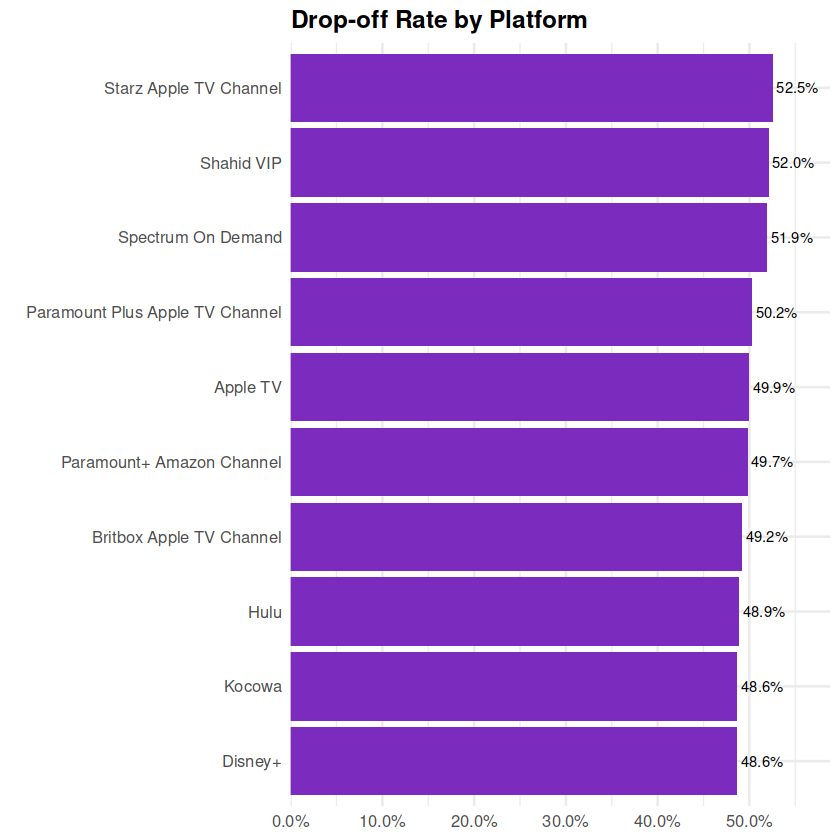

In [7]:
# Plot: drop-off rate by platform (Top 10) ----
churn_by_platform %>%
  slice_max(order_by = dropoff_rate, n = 10) %>%
  ggplot(aes(x = reorder(platform, dropoff_rate), y = dropoff_rate)) +
  geom_col(fill = PRIMARY_COLOR) +
  geom_text(aes(label = percent(dropoff_rate, accuracy = 0.1)), hjust = -0.1, size = 3) +
  coord_flip() +
  scale_y_continuous(labels = percent_format(accuracy = 0.1), expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "Drop-off Rate by Platform",
    x = NULL,
    y = NULL
  )

Drop-off rates are very similar across platforms, ranging from 48% to 53%.

### Drop-off by Series

In [8]:
# Drop-off by series ----
dropoff_by_series <- df %>%
  group_by(show_id, title) %>%
  summarise(
    episodes = n(),
    dropoff_rate = mean(dropoff_rate, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(desc(dropoff_rate), desc(episodes))

dropoff_by_series %>% slice_head(n = 10)

show_id,title,episodes,dropoff_rate
<dbl>,<chr>,<int>,<dbl>
281013,Dynamite Kiss,14,0.5888571
75219,9-1-1,10,0.5761000
87108,Chernobyl,5,0.5704000
271823,Playing Gracie Darling,6,0.5621667
286801,Monster: The Ed Gein Story,8,0.5618750
124364,FROM,10,0.5612000
113962,Lioness,8,0.5572500
85077,The Chosen,8,0.5565000
764,Midsomer Murders,5,0.5524000


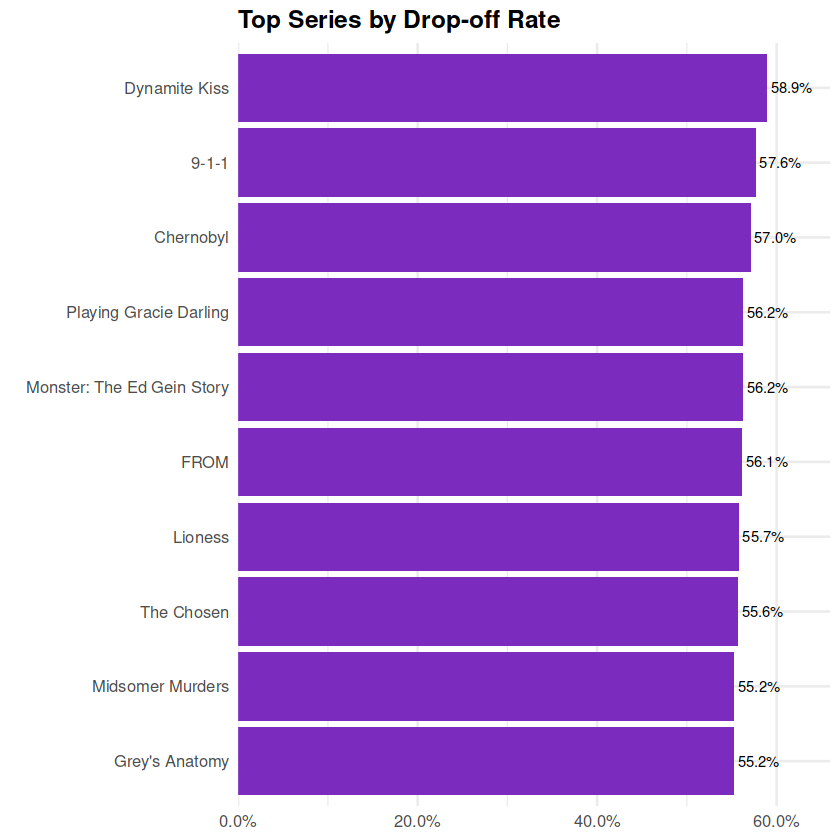

In [9]:
# Plot: top series by overall drop-off rate (Top 10) ----
dropoff_by_series %>%
  slice_max(order_by = dropoff_rate, n = 10) %>%
  ggplot(aes(x = reorder(title, dropoff_rate), y = dropoff_rate)) +
  geom_col(fill = PRIMARY_COLOR) +
  geom_text(aes(label = percent(dropoff_rate, accuracy = 0.1)), hjust = -0.1, size = 3) +
  coord_flip() +
  scale_y_continuous(labels = percent_format(accuracy = 0.1), expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "Top Series by Drop-off Rate",
    x = NULL,
    y = NULL
  )

### Early Drop-off

We define early drop-off as the average drop-off rate across the first three episodes of each series.  
This helps identify shows that lose a lot of viewers right at the start.

In [10]:
# Early episodes (first 3) ----
early_by_series <- df %>%
  filter(episode_number <= 3) %>%
  group_by(show_id, title) %>%
  summarise(
    episodes_used = n(),
    early_dropoff_rate = mean(dropoff_rate, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(desc(early_dropoff_rate))

early_by_series %>% slice_head(n = 10)

show_id,title,episodes_used,early_dropoff_rate
<dbl>,<chr>,<int>,<dbl>
13945,"Gute Zeiten, schlechte Zeiten",3,0.6576667
154770,Hello Saturday,3,0.6506667
95897,Overflow,3,0.6366667
1966,Horizon,3,0.6146667
1920,Twin Peaks,3,0.6130000
95396,Severance,3,0.6126667
124364,FROM,3,0.6103333
1508,Dancing with the Stars,3,0.6090000
42912,Inazuma Eleven,3,0.6066667


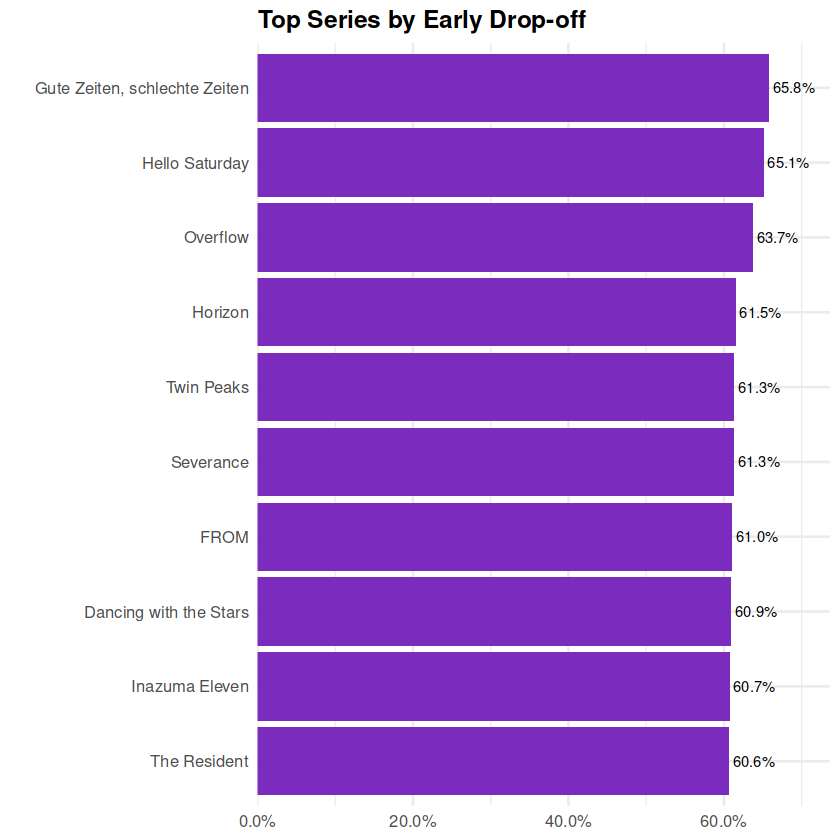

In [11]:
# Plot: top series by early drop-off (Top 10) ----
early_by_series %>%
  slice_max(order_by = early_dropoff_rate, n = 10) %>%
  ggplot(aes(x = reorder(title, early_dropoff_rate), y = early_dropoff_rate)) +
  geom_col(fill = PRIMARY_COLOR) +
  geom_text(aes(label = percent(early_dropoff_rate, accuracy = 0.1)), hjust = -0.1, size = 3) +
  coord_flip() +
  scale_y_continuous(labels = percent_format(accuracy = 0.1), expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "Top Series by Early Drop-off",
    x = NULL,
    y = NULL
  )

### Late Drop-off

We define late drop-off as the average drop-off rate across the last three episodes of each series.  
This helps identify shows that lose viewers toward the end.

In [12]:
# Late episodes (last 3) ----
last_ep_per_show <- df %>%
  group_by(show_id) %>%
  summarise(last_episode = max(episode_number, na.rm = TRUE), .groups = "drop")

late_by_series <- df %>%
  inner_join(last_ep_per_show, by = "show_id") %>%
  filter(episode_number >= (last_episode - 2)) %>%
  group_by(show_id, title) %>%
  summarise(
    episodes_used = n(),
    late_dropoff_rate = mean(dropoff_rate, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(desc(late_dropoff_rate))

late_by_series %>% slice_head(n = 10)

show_id,title,episodes_used,late_dropoff_rate
<dbl>,<chr>,<int>,<dbl>
292035,Revenged Love,3,0.7206667
82596,Emily in Paris,3,0.6526667
79744,The Rookie,3,0.6490000
1416,Grey's Anatomy,3,0.6450000
12971,Dragon Ball Z,3,0.6406667
85077,The Chosen,3,0.6340000
271823,Playing Gracie Darling,3,0.6273333
4601,Law & Order: Criminal Intent,3,0.6256667
269,One Tree Hill,3,0.6236667


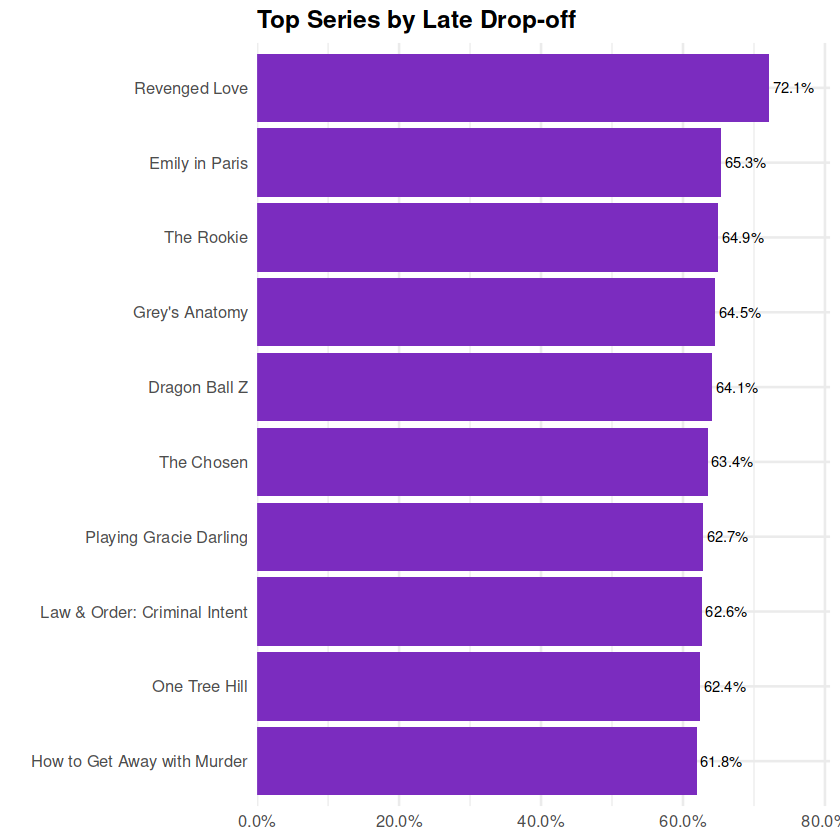

In [13]:
# Plot: top series by late drop-off (Top 10) ----
late_by_series %>%
  slice_max(order_by = late_dropoff_rate, n = 10) %>%
  ggplot(aes(x = reorder(title, late_dropoff_rate), y = late_dropoff_rate)) +
  geom_col(fill = PRIMARY_COLOR) +
  geom_text(aes(label = percent(late_dropoff_rate, accuracy = 0.1)), hjust = -0.1, size = 3) +
  coord_flip() +
  scale_y_continuous(labels = percent_format(accuracy = 0.1), expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "Top Series by Late Drop-off",
    x = NULL,
    y = NULL
  )

### Comparing Early vs Late Drop-off Patterns

The next two charts compare early and late behavior for the same set of series:

- In Late Drop-off for Series with High Early Drop-off, the bar shows the early drop-off rate and the point shows the late drop-off rate.
- In Early Drop-off for Series with High Late Drop-off, the bar shows the late drop-off rate and the point shows the early drop-off rate.

This makes it easier to see whether a series that drops viewers early also drops them late or the opposite.

In [14]:
# High early drop-off -> what happens late? ----
top_n <- 10

top_early <- early_by_series %>%
  slice_max(order_by = early_dropoff_rate, n = top_n) %>%
  select(show_id, title, early_dropoff_rate)

early_to_late <- top_early %>%
  left_join(late_by_series, by = c("show_id", "title"))

early_to_late

show_id,title,early_dropoff_rate,episodes_used,late_dropoff_rate
<dbl>,<chr>,<dbl>,<int>,<dbl>
13945,"Gute Zeiten, schlechte Zeiten",0.6576667,3,0.4760000
154770,Hello Saturday,0.6506667,3,0.4590000
95897,Overflow,0.6366667,3,0.4630000
1966,Horizon,0.6146667,3,0.5180000
1920,Twin Peaks,0.6130000,3,0.5416667
95396,Severance,0.6126667,3,0.4603333
124364,FROM,0.6103333,3,0.5343333
1508,Dancing with the Stars,0.6090000,3,0.4320000
42912,Inazuma Eleven,0.6066667,3,0.4870000


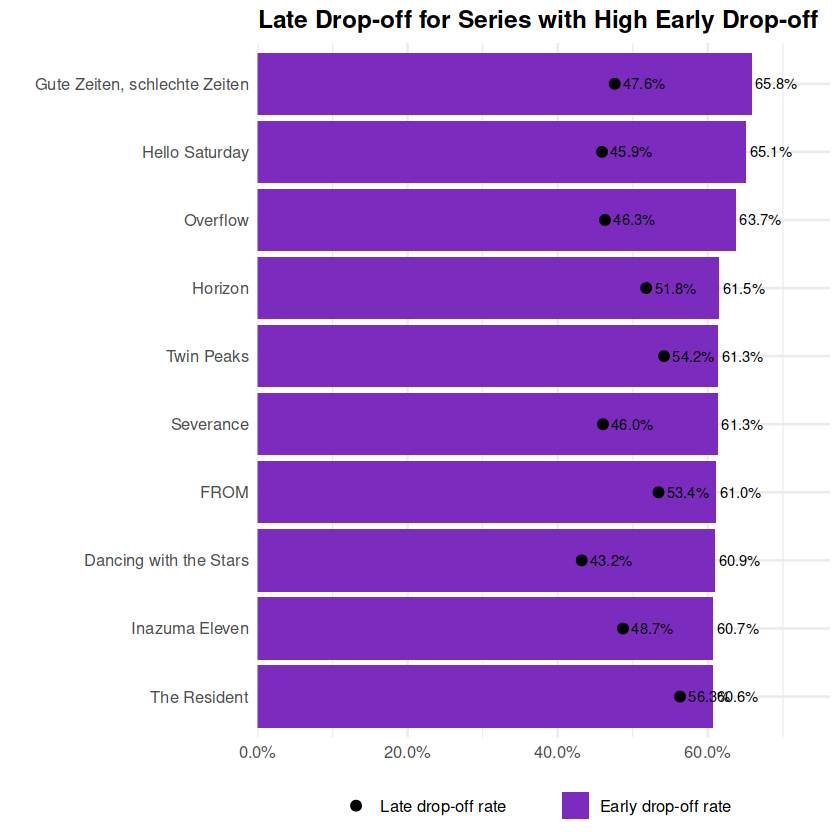

In [15]:
# Plot: For high-early series, compare early (bars) vs late (points) ----
early_to_late %>%
  mutate(title = reorder(title, early_dropoff_rate)) %>%
  ggplot(aes(x = title)) +
  geom_col(aes(y = early_dropoff_rate, fill = "Early drop-off rate"), alpha = 1) +
  geom_point(aes(y = late_dropoff_rate, color = "Late drop-off rate"), size = 2.2) +
  geom_text(aes(y = early_dropoff_rate, label = percent(early_dropoff_rate, accuracy = 0.1)),
            hjust = -0.1, size = 3) +
  geom_text(aes(y = late_dropoff_rate, label = percent(late_dropoff_rate, accuracy = 0.1), color = "Late drop-off rate"),
            hjust = -0.2, vjust = 0.5, size = 3, show.legend = FALSE) +
  coord_flip() +
  scale_y_continuous(labels = percent_format(accuracy = 0.1), expand = expansion(mult = c(0, 0.16))) +
  scale_fill_manual(values = c("Early drop-off rate" = PRIMARY_COLOR), name = NULL) +
  scale_color_manual(values = c("Late drop-off rate" = "black"), name = NULL) +
  theme(
    legend.position = "bottom") +
  labs(
    title = "Late Drop-off for Series with High Early Drop-off",
    x = NULL,
    y = NULL
  )

A few series show extremely high early drop-off (e.g., Guilty Zaytin, Holy Saturday, Overflow, Severance, Dancing with the Stars). For these titles, the late drop-off rate is noticeably lower, suggesting that many viewers who make it past the opening episodes are more likely to stay engaged through the end.

In [16]:
# High late drop-off -> did it already happen early? ----
top_late <- late_by_series %>%
  slice_max(order_by = late_dropoff_rate, n = top_n) %>%
  select(show_id, title, late_dropoff_rate)

late_to_early <- top_late %>%
  left_join(early_by_series, by = c("show_id", "title"))

late_to_early

show_id,title,late_dropoff_rate,episodes_used,early_dropoff_rate
<dbl>,<chr>,<dbl>,<int>,<dbl>
292035,Revenged Love,0.7206667,3,0.4853333
82596,Emily in Paris,0.6526667,3,0.4813333
79744,The Rookie,0.6490000,3,0.3686667
1416,Grey's Anatomy,0.6450000,3,0.4453333
12971,Dragon Ball Z,0.6406667,3,0.5030000
85077,The Chosen,0.6340000,3,0.5456667
271823,Playing Gracie Darling,0.6273333,3,0.4970000
4601,Law & Order: Criminal Intent,0.6256667,3,0.4200000
269,One Tree Hill,0.6236667,3,0.4573333


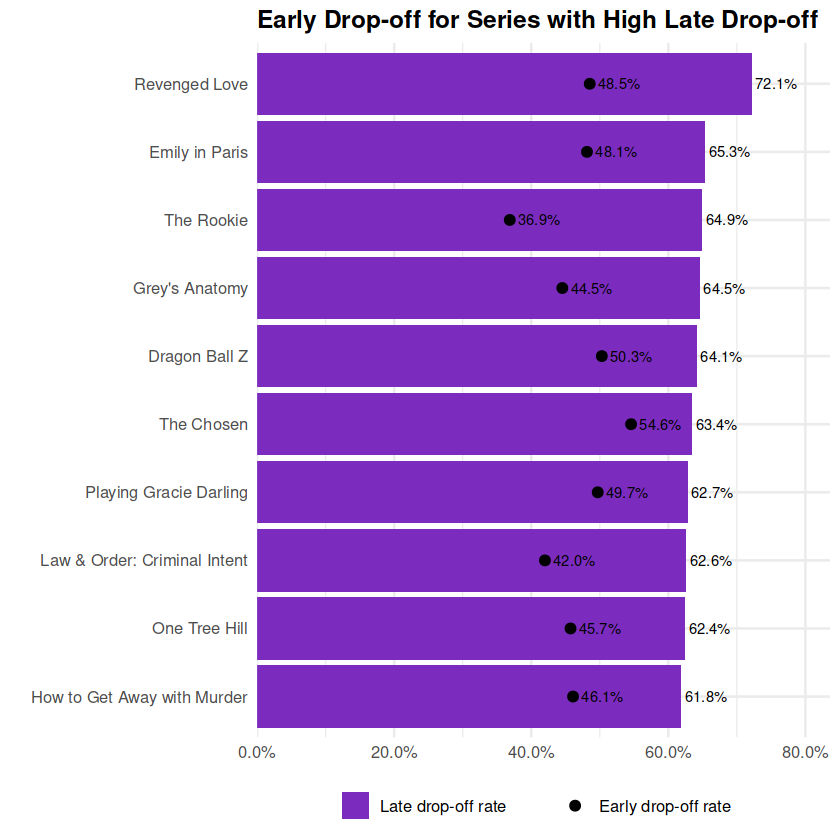

In [17]:
# Plot: For high-late series, compare late (bars) vs early (points) ----
late_to_early %>%
  mutate(title = reorder(title, late_dropoff_rate)) %>%
  ggplot(aes(x = title)) +
  geom_col(aes(y = late_dropoff_rate, fill = "Late drop-off rate"), alpha = 1) +
  geom_point(aes(y = early_dropoff_rate, color = "Early drop-off rate"), size = 2.2) +
  geom_text(aes(y = late_dropoff_rate, label = percent(late_dropoff_rate, accuracy = 0.1)),
            hjust = -0.1, size = 3) +
  geom_text(aes(y = early_dropoff_rate, label = percent(early_dropoff_rate, accuracy = 0.1)),
            hjust = -0.2, vjust = 0.5, size = 3, color = "black", show.legend = FALSE) +
  coord_flip() +
  scale_y_continuous(labels = percent_format(accuracy = 0.1), expand = expansion(mult = c(0, 0.16))) +
  scale_fill_manual(values = c("Late drop-off rate" = PRIMARY_COLOR), name = NULL) +
  scale_color_manual(values = c("Early drop-off rate" = "black"), name = NULL) +
  guides(
    fill  = guide_legend(order = 1),
    color = guide_legend(order = 2)
  ) +
  theme(
    legend.position = "bottom"
  ) +
  labs(
    title = "Early Drop-off for Series with High Late Drop-off",
    x = NULL,
    y = NULL
  )

Some series peak in late drop-off (e.g., Ravaged Love, Emily in Paris, The Rock, Grey’s Anatomy, Dragon Ball, Law & Order: Criminal Intent). For these titles, early drop-off is still elevated but tends to be lower than their late-episode drop-off, hinting at end-of-season fatigue or pacing/hook issues later.

## Content Based Analysis

### Content Characteristics Explained
These content features are included as synthetically generated variables in the dataset.  
They are designed to approximate attributes commonly analyzed in streaming contexts:

- Cognitive Load: how mentally demanding the content is consistently higher in this dataset = more complex narrative / higher attention demand
- Pacing Score: speed of narrative progression higher = faster pacing
- Hook Strength: how strongly early content captures attention higher = stronger initial hook
- Dialogue Density: how dialogue-driven the content is consistently higher in this dataset = more dialogue relative to action/visual storytelling
- Visual Intensity: how visually/action intense the content is consistently higher in this dataset = more visual stimulation

In later steps, we group selected metrics into Low / Medium / High Profile using quantiles for interpretability.

### Drop-off by Genre

In [18]:
# Drop-off by genre ----
dropoff_by_genre <- df %>%
  group_by(genre) %>%
  summarise(
    episodes = n(),
    dropoff_rate = mean(dropoff_rate),
    avg_dropoff_probability = mean(dropoff_rate),
    .groups = "drop"
  ) %>%
  arrange(desc(dropoff_rate))

dropoff_by_genre

genre,episodes,dropoff_rate,avg_dropoff_probability
<chr>,<int>,<dbl>,<dbl>
Drama,6142,0.5147584,0.5147584
Mystery,233,0.5012189,0.5012189
Western,71,0.4980563,0.4980563
War & Politics,51,0.4980392,0.4980392
Kids,632,0.4794905,0.4794905
Documentary,75,0.4792133,0.4792133
Reality,4005,0.4784367,0.4784367
Family,208,0.4778894,0.4778894
Soap,334,0.4768473,0.4768473


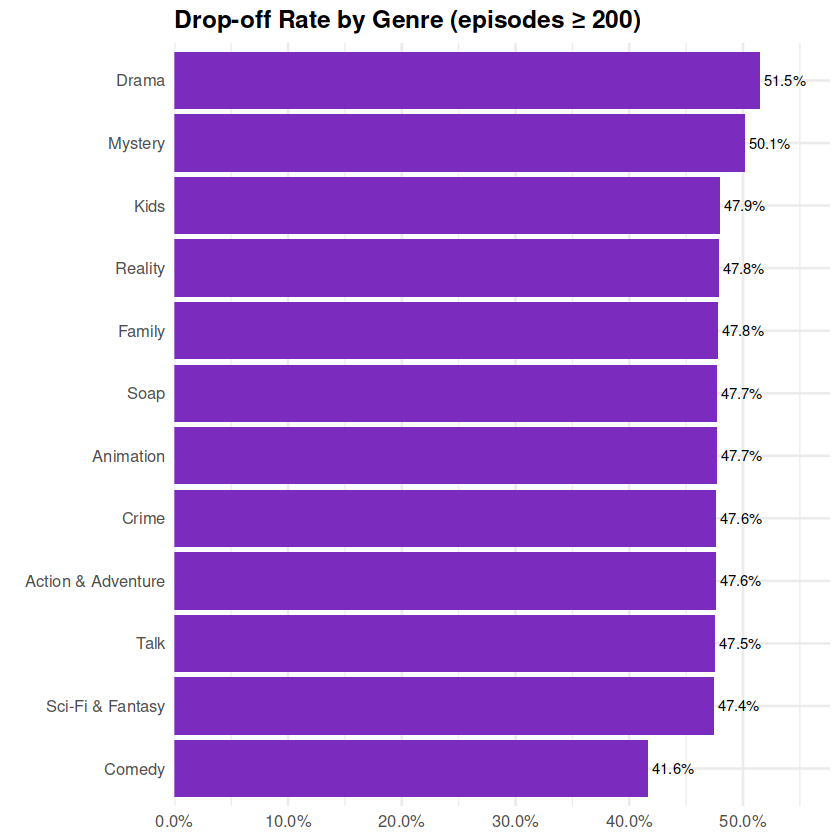

In [19]:
# Plot: Drop-off rate by genre (minimum volume filter) ----
min_genre_eps <- 200

dropoff_by_genre %>%
  filter(episodes >= min_genre_eps) %>%
  ggplot(aes(x = reorder(genre, dropoff_rate), y = dropoff_rate)) +
  geom_col(fill = PRIMARY_COLOR) +
  geom_text(aes(label = percent(dropoff_rate, accuracy = 0.1)), hjust = -0.1, size = 3) +
  coord_flip() +
  scale_y_continuous(labels = percent_format(accuracy = 0.1), expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = paste0("Drop-off Rate by Genre (episodes ≥ ", min_genre_eps, ")"),
    x = NULL,
    y = NULL
  )

Drop-off rates are very similar across genres. Drama and Mystery are slightly higher, while Comedy is slightly lower.

### Drop-off vs Cognitive Load
Here we treat cognitive load as a  variable to understand whether higher complexity is associated with higher drop-off.

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Failed to fit group -1.
Caused by error in `smooth.construct.cr.smooth.spec()`:
! x has insufficient unique values to support 10 knots: reduce k.”


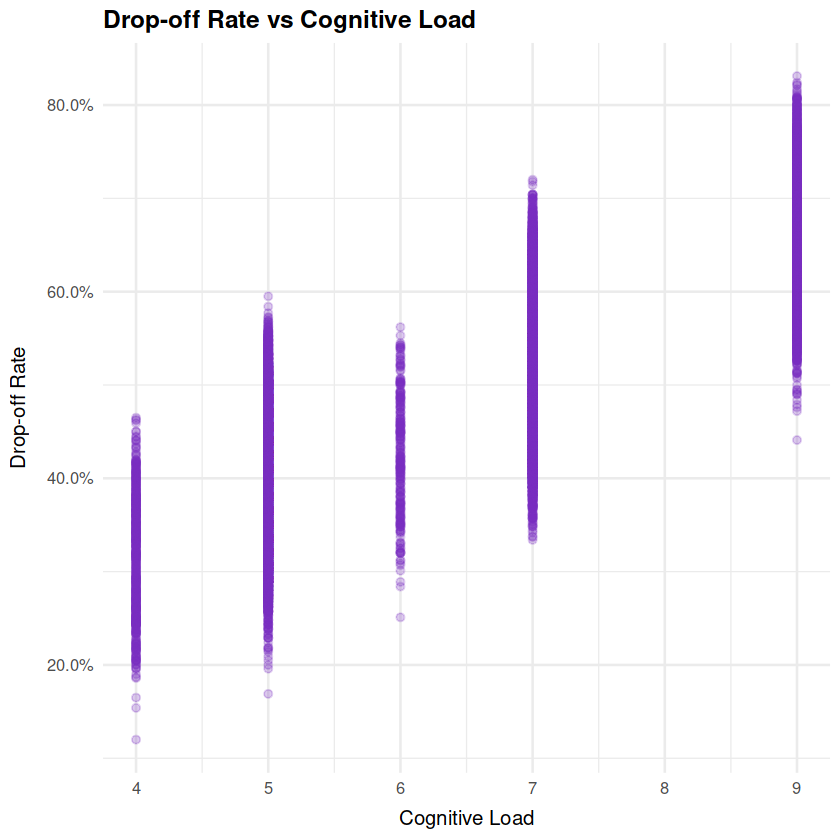

In [20]:
# Scatter: dropoff_rate vs cognitive_load ----
df %>%
  ggplot(aes(x = cognitive_load, y = dropoff_rate)) +
  geom_point(alpha = 0.25, color = PRIMARY_COLOR) +
  geom_smooth(se = FALSE, color = "black") +
  scale_y_continuous(labels = percent_format(accuracy = 0.1)) +
  labs(
    title = "Drop-off Rate vs Cognitive Load",
    x = "Cognitive Load",
    y = "Drop-off Rate"
  )

As cognitive load increases, the drop-off rate also increases. Episodes that demand more cognitive effort from viewers tend to be associated with higher abandonment.

In [21]:
# Build Low/Medium/High bands (tertiles) ----
content_bands <- df %>%
  mutate(
    pacing_band = case_when(
      ntile(pacing_score, 3) == 1 ~ "Low",
      ntile(pacing_score, 3) == 2 ~ "Medium",
      TRUE ~ "High"
    ),
    hook_band = case_when(
      ntile(hook_strength, 3) == 1 ~ "Low",
      ntile(hook_strength, 3) == 2 ~ "Medium",
      TRUE ~ "High"
    ),
    dialogue_band = case_when(
      ntile(dialogue_density, 3) == 1 ~ "Low",
      ntile(dialogue_density, 3) == 2 ~ "Medium",
      TRUE ~ "High"
    ),
    visual_band = case_when(
      ntile(visual_intensity, 3) == 1 ~ "Low",
      ntile(visual_intensity, 3) == 2 ~ "Medium",
      TRUE ~ "High"
    )
  )

content_bands %>% select(pacing_band, hook_band, dialogue_band, visual_band) %>% summary()

 pacing_band         hook_band         dialogue_band      visual_band       
 Length:33171       Length:33171       Length:33171       Length:33171      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

### Drop-off by Content Profile
We compare drop-off rates across Low/Medium/High groups for each content feature.

In [22]:
# Drop-off rate by content profiles ----
band_summary <- content_bands %>%
  select(dropoff_rate, pacing_band, hook_band, dialogue_band, visual_band) %>%
  pivot_longer(
    cols = c(pacing_band, hook_band, dialogue_band, visual_band),
    names_to = "feature",
    values_to = "band"
  ) %>%
  mutate(
    feature = case_when(
      feature == "pacing_band" ~ "Pacing",
      feature == "hook_band" ~ "Hook",
      feature == "dialogue_band" ~ "Dialogue",
      feature == "visual_band" ~ "Visual",
      TRUE ~ feature
    ),
    band = factor(band, levels = c("Low", "Medium", "High"))
  ) %>%
  group_by(feature, band) %>%
  summarise(
    episodes = n(),
    dropoff_rate = mean(dropoff_rate, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(feature, band)

band_summary

feature,band,episodes,dropoff_rate
<chr>,<fct>,<int>,<dbl>
Dialogue,Low,11057,0.5550106
Dialogue,Medium,11057,0.4404423
Dialogue,High,11057,0.4398459
Hook,Low,11057,0.5446213
Hook,Medium,11057,0.4793262
Hook,High,11057,0.4113513
Pacing,Low,11057,0.5612904
Pacing,Medium,11057,0.4480328
Pacing,High,11057,0.4259756


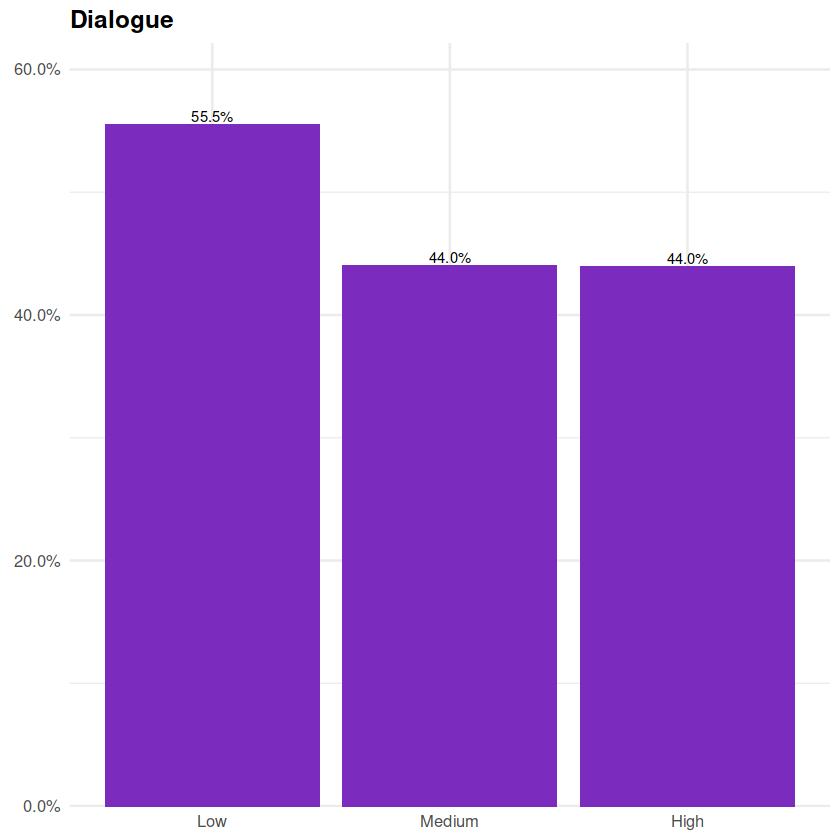

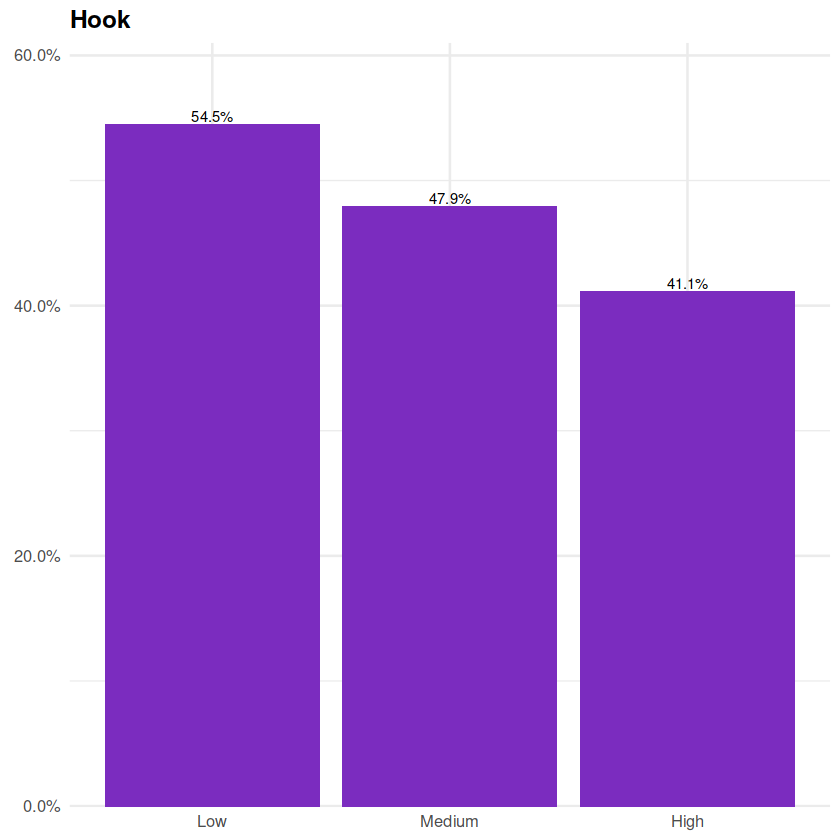

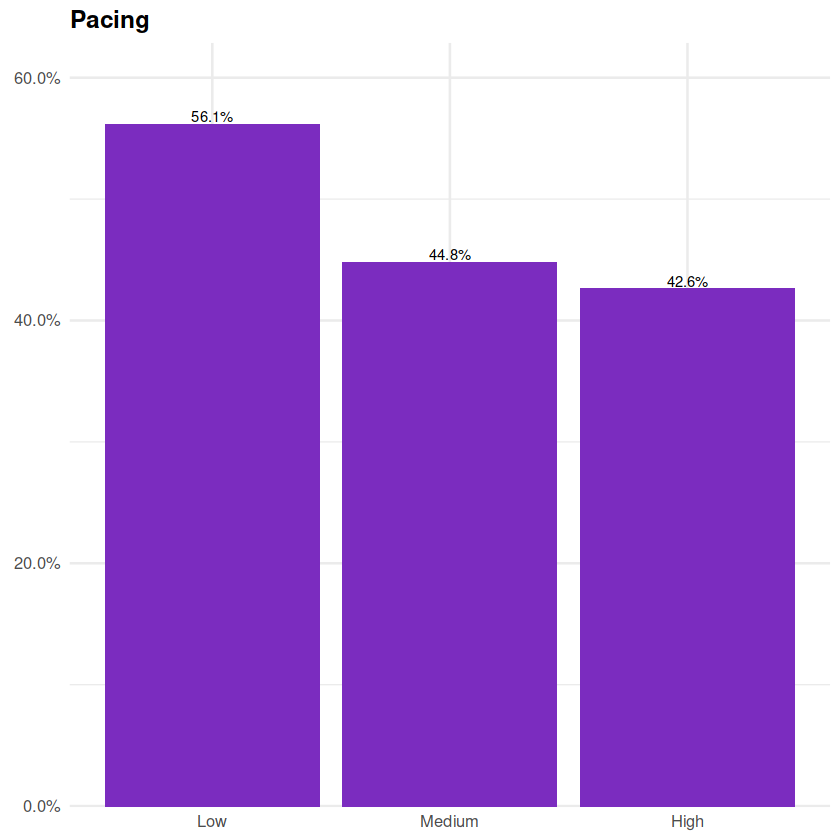

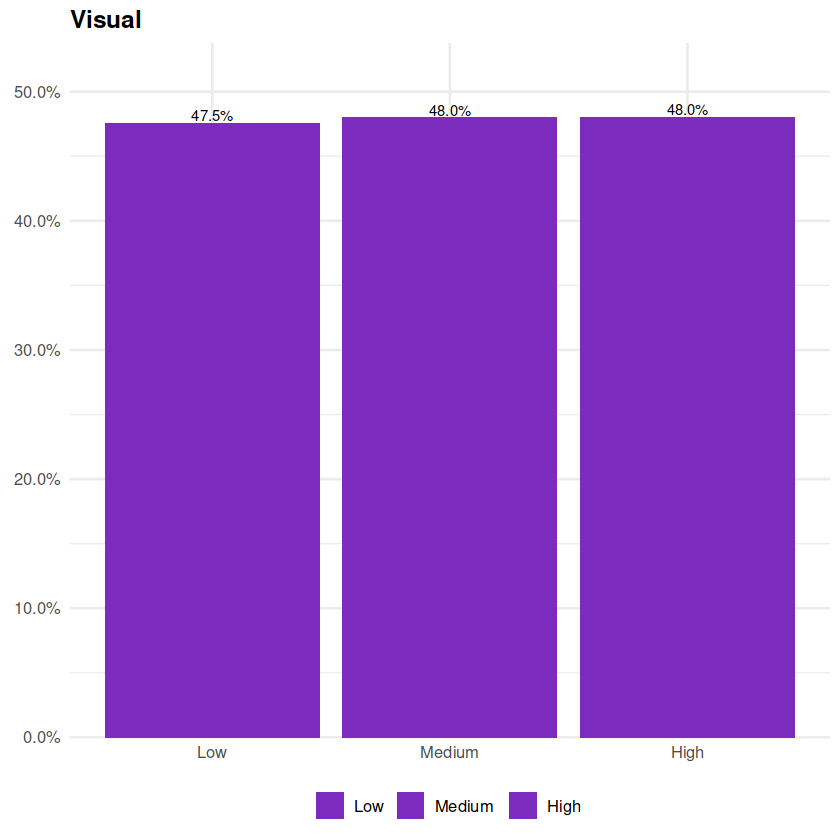

In [23]:
# Plot: drop-off rate by content profiles (individual panels) ----
band_summary_clean <- band_summary %>%
  mutate(
    band = factor(band, levels = c("Low","Medium","High")),
    feature = str_remove(feature, " Profile$")
  )

plot_profile_feature <- function(feature_name, show_legend = FALSE) {
  p <- band_summary_clean %>%
    filter(feature == feature_name) %>%
    ggplot(aes(x = band, y = dropoff_rate, fill = band)) +
    geom_col() +
    geom_text(aes(label = percent(dropoff_rate, accuracy = 0.1)),
              vjust = -0.2, size = 3) +
    scale_y_continuous(labels = percent_format(accuracy = 0.1),
                       expand = expansion(mult = c(0, 0.12))) +
    scale_fill_manual(
      values = c("Low" = PRIMARY_COLOR, "Medium" = PRIMARY_COLOR, "High" = PRIMARY_COLOR),
      breaks = c("Low", "Medium", "High"),
      name = NULL
    ) +
    labs(
      title = feature_name,
      x = NULL,
      y = NULL
    )

  if (!show_legend) p <- p + theme(legend.position = "none")
  p
}

p_dialog  <- plot_profile_feature("Dialogue", show_legend = FALSE)
p_hook    <- plot_profile_feature("Hook", show_legend = FALSE)
p_pacing  <- plot_profile_feature("Pacing", show_legend = FALSE)
p_visual  <- plot_profile_feature("Visual", show_legend = TRUE) + theme(legend.position = "bottom")

p_dialog
p_hook
p_pacing
p_visual

For Dialogue Density, the drop-off rate is consistently higher in this dataset for a Low profile, while Medium and High profiles are lower and very similar.

For Hook Strength, higher hook profiles have lower drop-off rates.

For Pacing Score, the drop-off rate is consistently higher in this dataset for a Low profile, while Medium and High profiles are lower and very similar.

For Visual Intensity, drop-off rates are very similar across Low, Medium, and High profiles.

## Drop-off Drivers and Risk Signals

### Retention Risk Explained

The dataset includes a retention risk score higher values indicate higher expected risk of viewers dropping off.


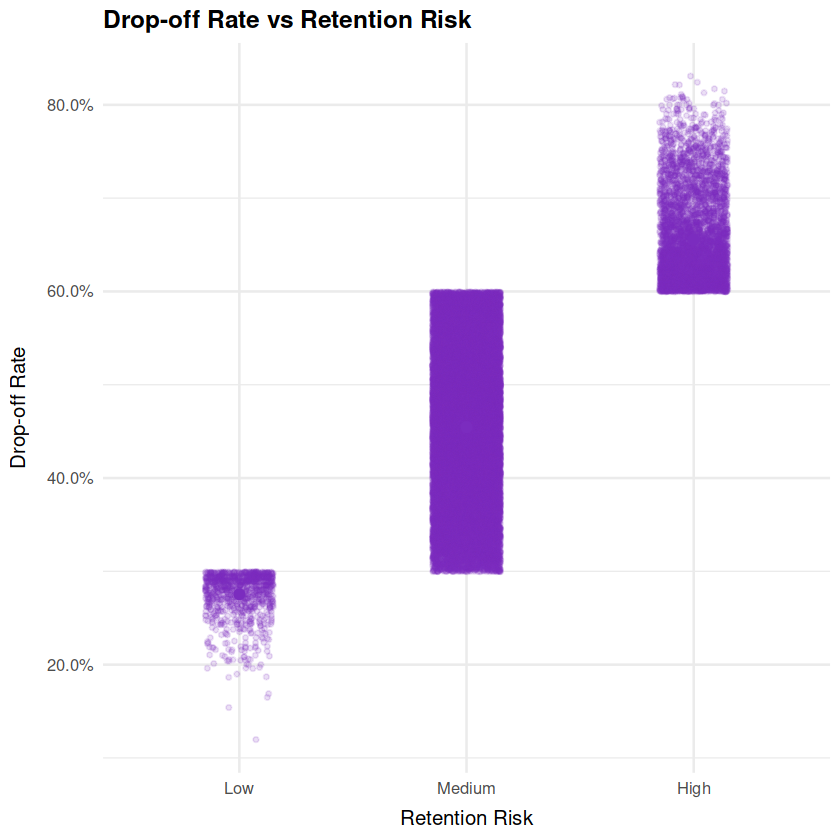

In [24]:
# Drop-off rate vs retention risk ----
df %>%
  mutate(
    retention_risk = stringr::str_to_title(stringr::str_trim(retention_risk)),
    retention_risk = factor(retention_risk, levels = c("Low", "Medium", "High"))
  ) %>%
  filter(!is.na(retention_risk)) %>%
  ggplot(aes(x = retention_risk, y = dropoff_rate)) +
  geom_jitter(width = 0.15, alpha = 0.15, size = 0.9, color = PRIMARY_COLOR) +
  stat_summary(fun = mean, geom = "point", size = 2.2, color = PRIMARY_COLOR) +
  scale_y_continuous(labels = percent_format(accuracy = 0.1)) +
  labs(
    title = "Drop-off Rate vs Retention Risk",
    x = "Retention Risk",
    y = "Drop-off Rate"
  )

Retention risk aligns reasonably well with drop-off rate: Low risk tends to have lower drop-off, High risk tends to be somewhat higher, and most titles cluster around the Medium band with drop-off rates roughly in the mid range.

## Conclusion

### Key Insights

Across platforms, drop-off rates are very similar, typically ranging between 48% and 53%. This suggests that platform choice alone has limited influence on viewer drop-off compared to content-level characteristics.

Early and late episode analyses show that viewer drop-off is not uniform over time. Some series experience very high early drop-off but substantially lower drop-off toward the end, while others show the opposite pattern. Importantly, high drop-off at one stage does not necessarily imply high drop-off at another.

Genre-level differences are modest. Drama and Mystery tend to have slightly higher drop-off rates, while Comedy shows somewhat lower drop-off, but overall variation across genres remains limited.

Cognitive load is strongly associated with viewer drop-off. As cognitive load increases, viewers are more likely to abandon episodes, indicating that more demanding content can negatively affect retention.

Content profile analysis reveals distinct patterns. Lower dialogue density and lower pacing are associated with higher drop-off, whereas stronger hooks are associated with lower drop-off. Visual intensity, by contrast, shows relatively stable drop-off rates across low, medium, and high profiles.

Retention risk categories align reasonably well with observed viewer drop-off. Low-risk content generally exhibits lower drop-off, high-risk content shows higher abandonment, and most series cluster in the medium-risk range.

### Practical Applications

From a content strategy perspective, these findings highlight the importance of early-episode engagement without assuming that initial abandonment will persist throughout a series. Sustaining viewer interest requires consistent pacing, effective hooks, and careful management of cognitive load.

Given the limited variation across platforms and genres, optimization efforts are likely to be most effective when focused on content design rather than distribution channels. Retention risk metrics can serve as a useful high-level signal, but they should be interpreted alongside detailed drop-off patterns to support investment, development, and optimization decisions.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5562491b-a98e-4925-a811-76400f1e61c7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>